In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
cleaned_trip_df = pd.read_csv('../data/trip_cleaned.csv')

In [6]:
trip_distr_df = cleaned_trip_df[['hack_license', 'pickup_taxizone_id', 'dropoff_taxizone_id', 
                            'first_pickup', 'last_dropoff']].copy()

## Get the next PU zone, Ignore the last trip of a shift

In [7]:
trip_distr_df['pickup_taxizone_id_next'] = trip_distr_df.groupby('hack_license')['pickup_taxizone_id'].shift(-1)
trip_distr_df = trip_distr_df.loc[trip_distr_df['last_dropoff'] == 0]
trip_distr_df.dropna(subset=['pickup_taxizone_id_next'], inplace=True) ## last trip of a driver in the raw df

## Compute counts and percentage of each dropoff zone

In [8]:
trip_distr_cnt = trip_distr_df.groupby(['dropoff_taxizone_id', 'pickup_taxizone_id_next'], as_index=False).size().reset_index()
trip_distr_cnt.rename(columns={'dropoff_taxizone_id': 'DO_zone', 
                      'pickup_taxizone_id_next': 'next_PU_zone',
                      0: 'count'}, inplace=True)

trip_distr_total = trip_distr_df.groupby(['dropoff_taxizone_id'], as_index=False).size().reset_index()
trip_distr_total.rename(columns={'dropoff_taxizone_id': 'DO_zone',
                      0: 'total'}, inplace=True)

trip_distr_cnt_summary = trip_distr_cnt.merge(trip_distr_total, on='DO_zone', how='right')
trip_distr_cnt_summary['percent'] = trip_distr_cnt_summary['count']/trip_distr_cnt_summary['total']*100

### By percent

Text(0.5, 1, 'Percent Next PU Zone by DO zones')

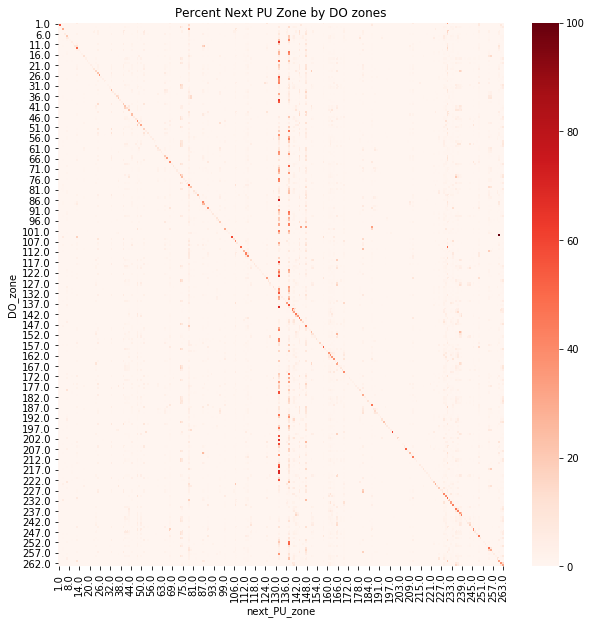

In [9]:
pivot_percent = trip_distr_cnt_summary.pivot_table(index='DO_zone', columns='next_PU_zone', 
                                                   values='percent').fillna(0)
fig, ax = plt.subplots(1,1, figsize=(10,10))
sns.heatmap(pivot_percent, ax=ax, cmap='Reds')
ax.set_title('Percent Next PU Zone by DO zones')

In [15]:
trip_distr_cnt_summary.loc[trip_distr_cnt_summary['percent'] > 40]['next_PU_zone'].unique()

array([  2., 132.,  13., 138.,  68.,  79.,  87., 261., 105., 110., 231.,
       113., 114., 140., 142., 144., 148., 158., 186., 199., 207., 211.,
       229., 234., 236., 237., 239., 246., 249., 255.])

The three vertical lines are
* zone 132 = JFK
* zone 138 = LGA
* zone 148 = Lower East Side

### By counts

Text(0.5, 1, 'Log Next PU Zone Counts by DO zones')

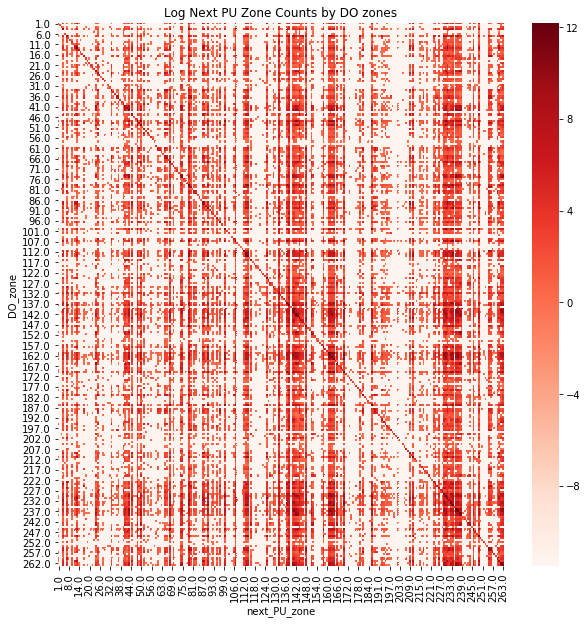

In [10]:
pivot_counts = trip_distr_cnt_summary.pivot_table(index='DO_zone', columns='next_PU_zone', 
                                                   values='count').fillna(0)
# np.log(pivot_counts + 1e-5)
fig, ax = plt.subplots(1,1, figsize=(10,10))
sns.heatmap(np.log(pivot_counts + 1e-5), ax=ax, cmap='Reds')
ax.set_title('Log Next PU Zone Counts by DO zones')

In [ ]:
geo_loc_df = cleaned_trip_df.groupby('dropoff_taxizone_id', as_index=False)[['dropoff_latitude', 'dropoff_longitude']].agg('mean').reset_index()

In [ ]:
def plot_dropoff_zones(PU_zone, ax):
    temp = cleaned_trip_df.loc[cleaned_trip_df['pickup_taxizone_id'] == PU_zone]

    lat = [geo_loc_df.loc[geo_loc_df['dropoff_taxizone_id'] == z, 'dropoff_latitude'].values[0] for z in temp['dropoff_taxizone_id']]
    long = [geo_loc_df.loc[geo_loc_df['dropoff_taxizone_id'] == z, 'dropoff_longitude'].values[0] for z in temp['dropoff_taxizone_id']]

#     fig, ax = plt.subplots(1,1)
    ax.scatter(geo_loc_df.loc[geo_loc_df['dropoff_taxizone_id'] == PU_zone, 'dropoff_latitude'].values[0],
               geo_loc_df.loc[geo_loc_df['dropoff_taxizone_id'] == PU_zone, 'dropoff_longitude'].values[0], s=50, alpha=0.2, label='PU')
    ax.scatter(lat, long, s=5, alpha=0.1)
    ax.set_title('Dropoff Zone for zone '+str(PU_zone))
    ax.legend()

In [ ]:
fig, ax = plt.subplots(1,1)
plot_dropoff_zones(200, ax)